In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import plotly.express as px
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Load dataset
data = pd.read_csv(r"/content/student_depression_dataset.csv")
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [ ]:
data.shape

(27901, 18)

In [ ]:
# Convert 'Depression' to integer (if not already)
data['Depression'] = data['Depression'].astype(int)

# Convert columns that should be categorical
cat_cols = ['Gender', 'City', 'Profession', 'Degree',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness']
for col in cat_cols:
    data[col] = data[col].astype('category')

# Check unique values in some columns to decide cleaning strategy
print("Unique values in 'Sleep Duration':", data['Sleep Duration'].unique())
print("Unique values in 'Financial Stress':", data['Financial Stress'].unique())

Unique values in 'Sleep Duration': ["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']
Unique values in 'Financial Stress': ['1.0' '2.0' '5.0' '3.0' '4.0' '?']


In [ ]:
# Define a function to extract numeric hours from Sleep Duration column
def extract_hours(s):
    # Find a number (including decimals)
    match = re.search(r"(\d+(\.\d+)?)", str(s))
    return float(match.group(1)) if match else np.nan

data['Sleep Duration'] = data['Sleep Duration'].apply(extract_hours)

# Convert Financial Stress to categorical if it represents levels (e.g., Low, Medium, High)
data['Financial Stress'] = data['Financial Stress'].astype('category')

# Verify changes
print(data[['Sleep Duration', 'Financial Stress']].head())

   Sleep Duration Financial Stress
0             5.0              1.0
1             5.0              2.0
2             5.0              1.0
3             7.0              5.0
4             5.0              1.0


In [ ]:
# Display missing values per column
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 id                                        0
Gender                                    0
Age                                       0
City                                      0
Profession                                0
Academic Pressure                         0
Work Pressure                             0
CGPA                                      0
Study Satisfaction                        0
Job Satisfaction                          0
Sleep Duration                           18
Dietary Habits                            0
Degree                                    0
Have you ever had suicidal thoughts ?     0
Work/Study Hours                          0
Financial Stress                          0
Family History of Mental Illness          0
Depression                                0
dtype: int64


In [ ]:
for col in ['Sleep Duration']:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

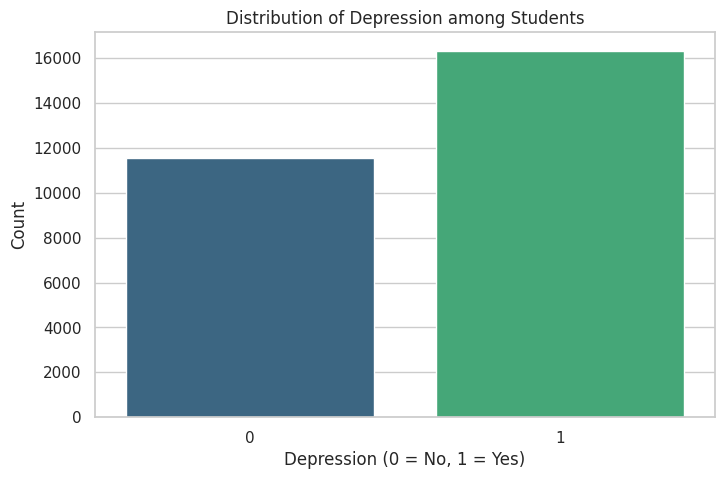

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Depression', data=data, palette="viridis")
plt.title("Distribution of Depression among Students")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

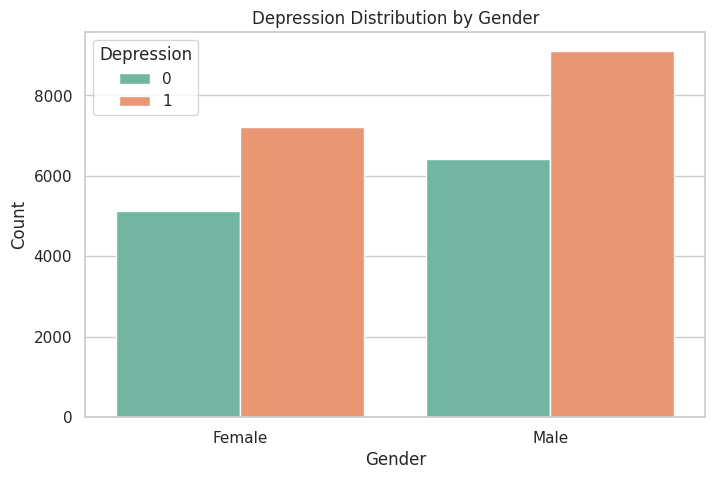

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Gender', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

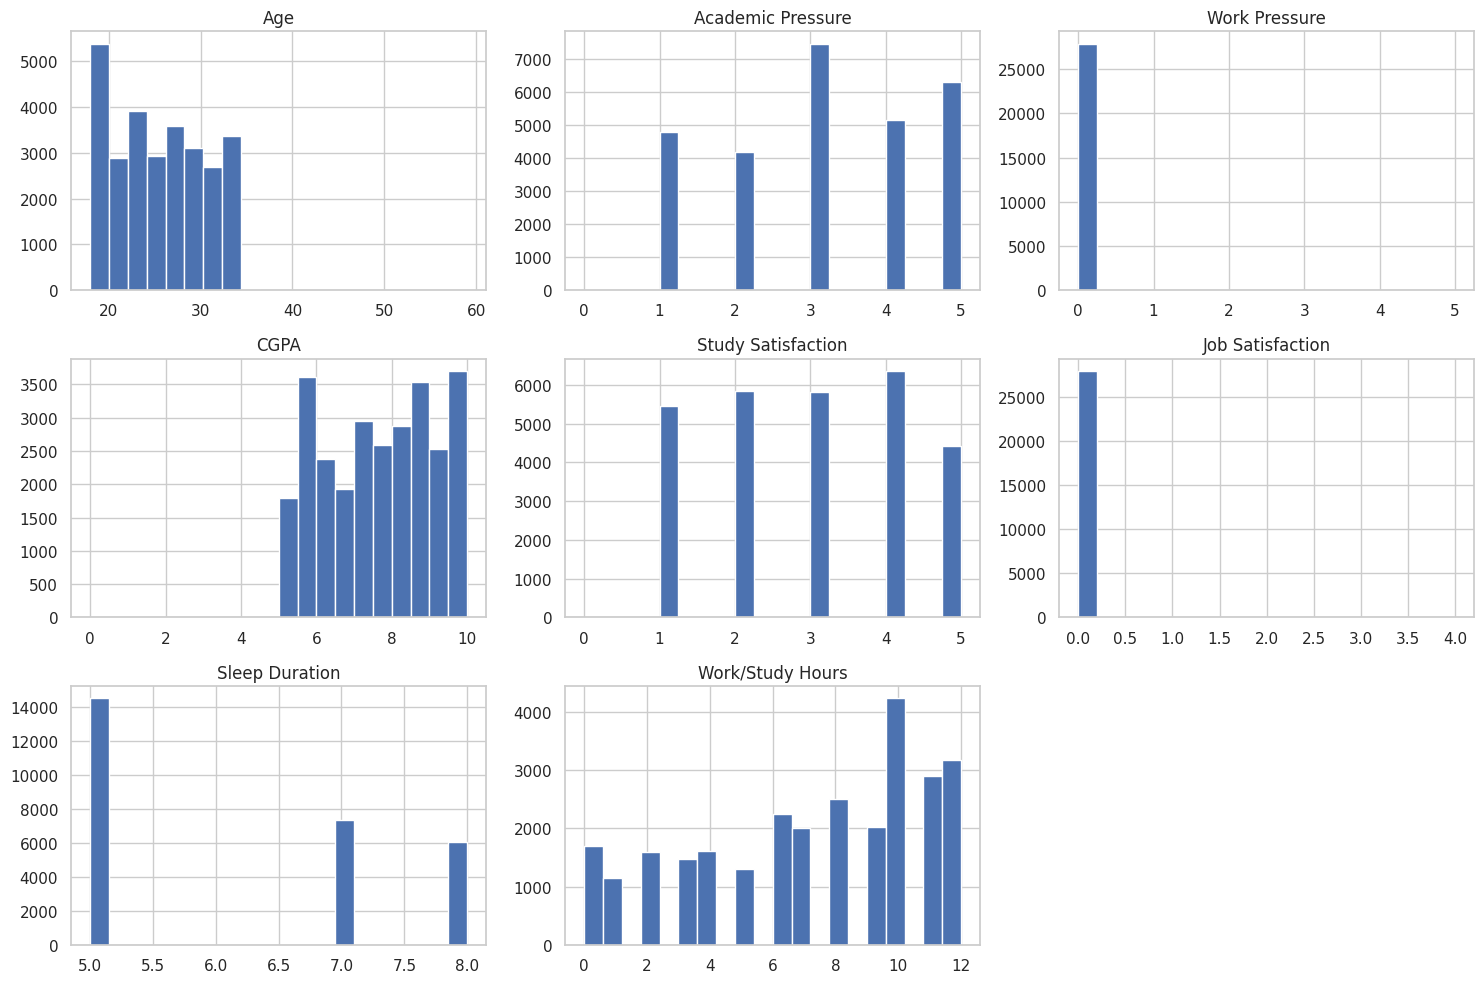

In [ ]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours']
data[num_features].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

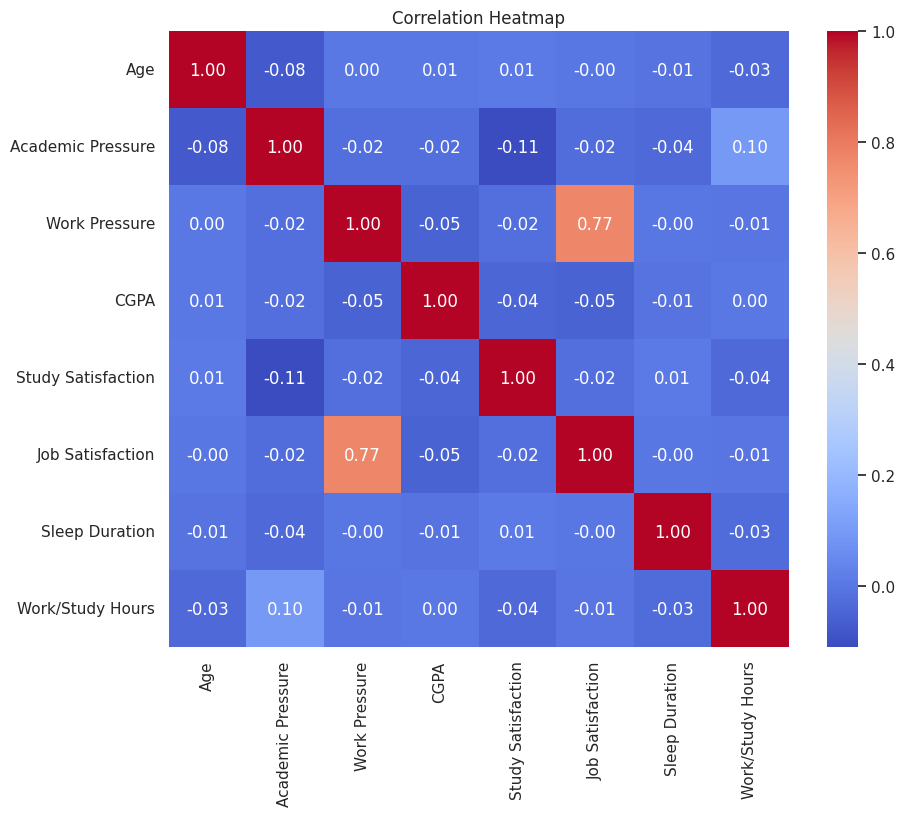

In [ ]:
plt.figure(figsize=(10,8))
num_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
            'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours']
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
fig = px.scatter(data, x="CGPA", y="Study Satisfaction", color="Depression",
                 hover_data=['Age', 'Gender', 'Academic Pressure'],
                 title="CGPA vs Study Satisfaction by Depression")
fig.show()

In [ ]:
# Separate the groups
group_dep = data[data['Depression'] == 1]['Academic Pressure']
group_non_dep = data[data['Depression'] == 0]['Academic Pressure']

# Print group sizes
print("Depressed group size:", len(group_dep))
print("Non-depressed group size:", len(group_non_dep))

# Only perform the test if both groups have at least 3 observations
if len(group_dep) >= 3 and len(group_non_dep) >= 3:
    # T-test
    t_stat, p_val = stats.ttest_ind(group_dep, group_non_dep)
    print("T-test statistic: {:.3f}, p-value: {:.3f}".format(t_stat, p_val))

    # Mann-Whitney U test
    u_stat, p_val_u = stats.mannwhitneyu(group_dep, group_non_dep)
    print("Mann-Whitney U test statistic: {:.3f}, p-value: {:.3f}".format(u_stat, p_val_u))
else:
    print("One of the groups does not have enough observations for statistical testing.")

Depressed group size: 16336
Non-depressed group size: 11565
T-test statistic: 90.119, p-value: 0.000
Mann-Whitney U test statistic: 145556846.500, p-value: 0.000


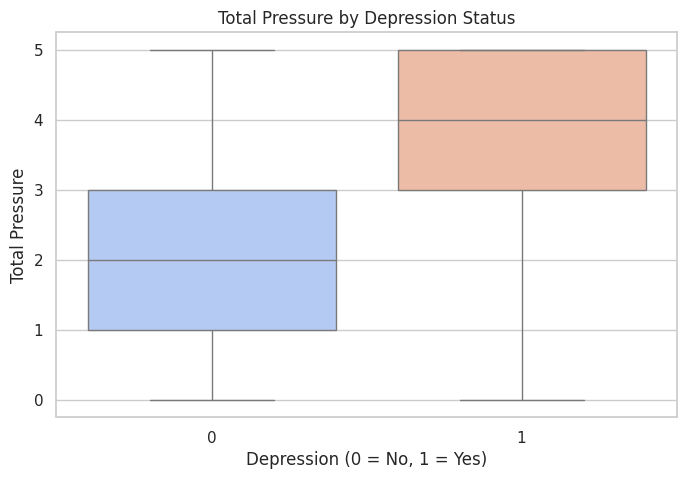

In [ ]:
data['Total Pressure'] = data['Academic Pressure'] + data['Work Pressure']

plt.figure(figsize=(8,5))
sns.boxplot(x='Depression', y='Total Pressure', data=data, palette="coolwarm")
plt.title("Total Pressure by Depression Status")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Total Pressure")
plt.show()

In [ ]:
# Select categorical columns to encode (excluding the target 'Depression')
cat_features = ['Gender', 'City', 'Profession', 'Degree',
                'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Financial Stress']

# Use one-hot encoding
data_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)

data_encoded.head()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Work/Study Hours,...,Degree_MSc,Degree_Others,Degree_PhD,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Financial Stress_?
0,2,33.0,5.0,0.0,8.97,2.0,0.0,5.0,Healthy,3.0,...,False,False,False,True,False,False,False,False,False,False
1,8,24.0,2.0,0.0,5.90,5.0,0.0,5.0,Moderate,3.0,...,False,False,False,False,True,True,False,False,False,False
2,26,31.0,3.0,0.0,7.03,5.0,0.0,5.0,Healthy,9.0,...,False,False,False,False,True,False,False,False,False,False
3,30,28.0,3.0,0.0,5.59,2.0,0.0,7.0,Moderate,4.0,...,False,False,False,True,True,False,False,False,True,False
4,32,25.0,4.0,0.0,8.13,3.0,0.0,5.0,Moderate,1.0,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
# Drop unwanted columns from the original dataframe
drop_cols = ['id', 'Depression', 'Have you ever had suicidal thoughts ?',
             'Family History of Mental Illness', 'Gender', 'City',
             'Profession', 'Degree', 'Financial Stress']
data_clean = data.drop(columns=drop_cols)

# Now encode only if you have any categorical variables left (or skip if all are numeric)
data_encoded = pd.get_dummies(data_clean, drop_first=True)

In [ ]:
# Print columns after encoding for debugging purposes
print("Columns after encoding:", data_encoded.columns.tolist())

# Define keys for the original categorical columns that were encoded
cat_keys = ["Have you ever had suicidal thoughts ?", "Family History of Mental Illness",
            "Gender", "City", "Profession", "Degree", "Financial Stress"]

# Identify dummy columns that contain any of these keys
dummy_cols = [col for col in data_encoded.columns if any(key in col for key in cat_keys)]

# Build a list of columns to drop only if they exist in data_encoded
drop_cols = []
for col in ['id', 'Depression']:
    if col in data_encoded.columns:
        drop_cols.append(col)
drop_cols += dummy_cols  # Add dummy columns to drop list

# Drop the columns
X = data_encoded.drop(columns=drop_cols)
# Ensure target variable is correctly defined. If 'Depression' was dropped, use the original target.
if 'Depression' in data_encoded.columns:
    y = data_encoded['Depression']
else:
    # If 'Depression' is not in data_encoded, use it from the original data
    y = data['Depression']

# Standardize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_feats = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
             'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
             'Work/Study Hours', 'Total Pressure']
X[num_feats] = scaler.fit_transform(X[num_feats])

print("Feature matrix shape:", X.shape)

Columns after encoding: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours', 'Total Pressure', 'Dietary Habits_Moderate', 'Dietary Habits_Others', 'Dietary Habits_Unhealthy']
Feature matrix shape: (27901, 12)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.72      2343
           1       0.79      0.83      0.81      3238

    accuracy                           0.77      5581
   macro avg       0.77      0.76      0.76      5581
weighted avg       0.77      0.77      0.77      5581



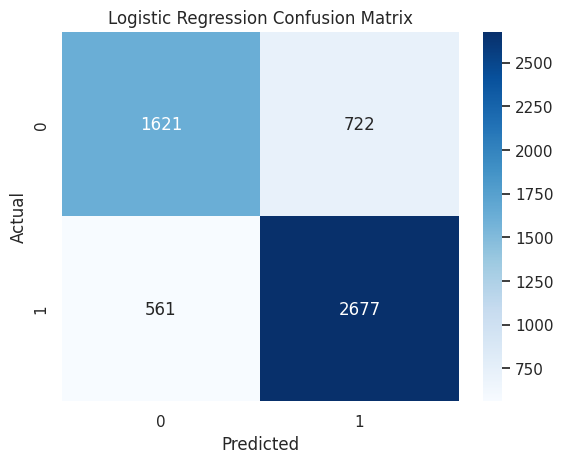

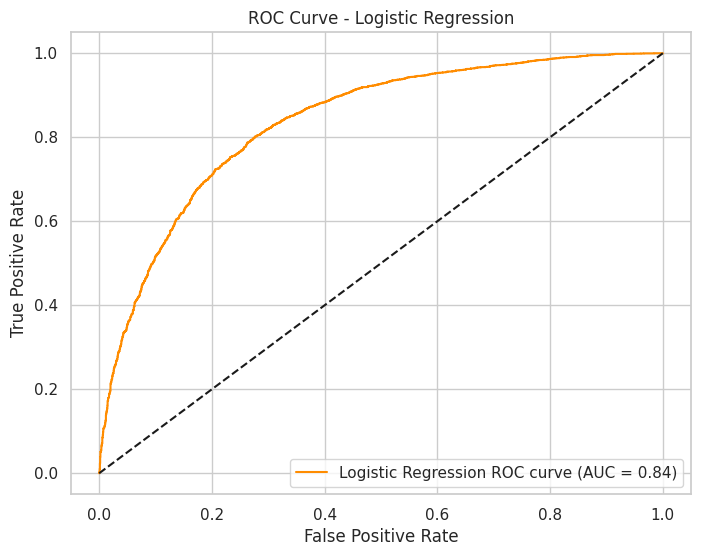

In [ ]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

# Confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt="d", cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_prob_log = log_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (AUC = {roc_auc_log:.2f})', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      2343
           1       0.77      0.81      0.79      3238

    accuracy                           0.75      5581
   macro avg       0.74      0.74      0.74      5581
weighted avg       0.75      0.75      0.75      5581



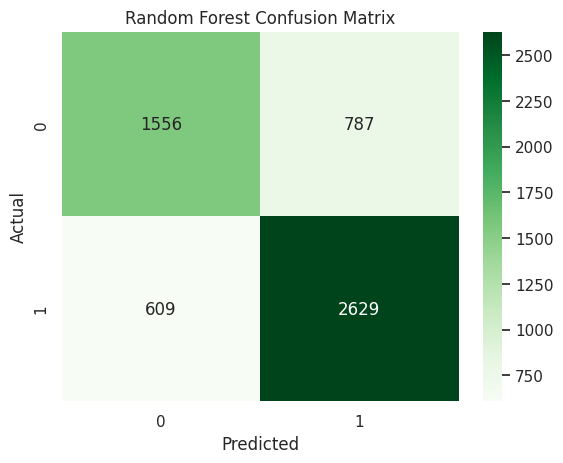

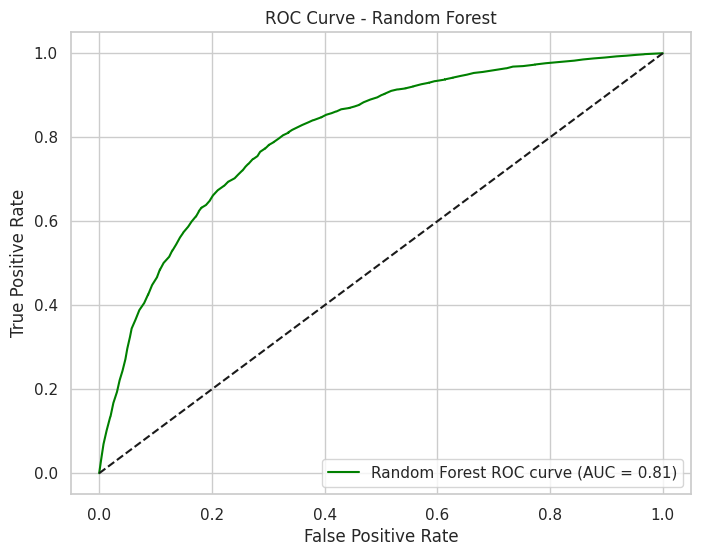

In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix for RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for RF
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})', color='green')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Final Thoughts
'''
Depression distribution from different genders look to be about the same amount compared to each other, it hard to tell
since we have less data on the female group. We can see that more people are depressed than people not depressed.
There is a slight correlation between academic preassure and work/study hours. And a big correlation between Job satisfaction and work presassure.
According to the CGPA vs Study Satisfaction by Depression we can see that people with a acedemic satisfactory of 1 tend to have higher chances
of having depression compared to students with a satisfactory of 5.  And large amount of students from the data that have depression tend to have
a  total preassure at 5 according to the Total Pressure by Depression Status plot.


'''

'\nDepression distribution from different genders look to be about the same amount compared to each other, it hard to tell \nsince we have less data on the female group. We can see that more people are depressed than people not depressed.\nThere is a slight correlation between academic preassure and work/study hours. And a big correlation between Job satisfaction and work presassure.\nAccording to the CGPA vs Study Satisfaction by Depression we can see that people with a acedemic satisfactory of 1 tend to have higher chances\nof having depression compared to students with a satisfactory of 5.  And large amount of students from the data that have depression tend to have\na  total preassure at 5 according to the Total Pressure by Depression Status plot.\n\n\n'

In [ ]:
!jupyter nbconvert -- to html Student_Depression_Evalution.ipynb

[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'html' matched no files
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 582, in convert_notebooks
    raise ValueError(msg)
ValueError: Please specify an output format with '--to <format>'.
The following formats are available: ['asciidoc', 'custom', 'html', 'latex', 'markdown', 'notebook', 'pdf', 'python', 'qtpdf', 'qtpng', 'rst',